In [1]:
import torch
#torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.memory_summary(device=None, abbreviated=False)
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch


/storage/home/hcoda1/7/btawfik3/.conda/envs/exist2025/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_path = "/storage/coda1/p-dsgt_clef2025/0/shared/exist/oldv2/EXIST_2025_Videos_Dataset/train_test/test_df.csv"
val_path = "/storage/coda1/p-dsgt_clef2025/0/shared/exist/oldv2/EXIST_2025_Videos_Dataset/train_test/valid_df.csv"
train_path = "/storage/coda1/p-dsgt_clef2025/0/shared/exist/oldv2/EXIST_2025_Videos_Dataset/train_test/train_df.csv"

import pandas as pd
import numpy as np

train_data_source = pd.read_csv(train_path)
train_data = train_data_source[['id_EXIST','video','text', 'target']]

val_data_source = pd.read_csv(val_path)
val_data = val_data_source[['id_EXIST','video','text', 'target']]

test_data_source = pd.read_csv(test_path)
test_data = test_data_source[['id_EXIST','video','text', 'target']]
test_data

,id_EXIST,video,text,target
0,220206,6910747250536893701.mp4,i’m getting so use to this now unamused_face ...,1
1,220558,6998726239087250693.mp4,"reply to to perform the stretch, fall forward ...",0
2,220180,6898724802001997057.mp4,"it's the small things, p.s these are only joke...",1
3,220479,6977700217835638021.mp4,"women we are so funny. j, women, women, wome...",1
4,220069,6841534512518761733.mp4,"we all waited. alright y'all, this is the ne...",0
...,...,...,...,...
190,220599,7014652808725155078.mp4,can i come live with someone else pls? clean t...,1
191,220337,6943386660419718406.mp4,"with walking into my purpose, a new challenge ...",0
192,220901,7119092344711859462.mp4,men are being lazy. you see ladies out here g...,1
193,220872,7108633528530701594.mp4,"xin chào officially, there are 42 offices with...",0


In [3]:

train_texts = train_data['text'].tolist()
train_labels =  train_data['target'].tolist()
train_video_ids =  train_data['video'].tolist()
train_exist_ids =  train_data['id_EXIST'].tolist()

test_texts = test_data['text'].tolist()
test_labels =  test_data['target'].tolist()
test_video_ids =  test_data['video'].tolist()
test_exist_ids =  test_data['id_EXIST'].tolist()

val_texts = val_data['text'].tolist()
val_labels =  val_data['target'].tolist()
val_video_ids =  val_data['video'].tolist()
val_exist_ids =  val_data['id_EXIST'].tolist()



In [4]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors='pt',
        max_length=512
    )

train_encodings = tokenize(train_texts)
test_encodings = tokenize(test_texts)
val_encodings = tokenize(val_texts)


In [5]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels, video_ids, exist_ids):
        self.encodings = encodings
        self.labels = labels
        self.video_ids = video_ids
        self.exist_ids = exist_ids

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['video_ids'] = self.video_ids[idx]
        item['exist_ids'] = self.exist_ids[idx]
        return item

train_dataset = TextDataset(train_encodings, train_labels, train_video_ids, train_exist_ids)
test_dataset = TextDataset(test_encodings, test_labels, test_video_ids, test_exist_ids)
val_dataset = TextDataset(val_encodings, val_labels, val_video_ids, val_exist_ids)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [7]:
model = RobertaForSequenceClassification.from_pretrained("roberta-large", num_labels=2)

# Freeze embeddings and encoder layers 0–20 (i.e., first 21 layers)
for name, param in model.named_parameters():
    if name.startswith("roberta.embeddings"):
        param.requires_grad = False
    elif "roberta.encoder.layer" in name:
        layer_num = int(name.split("layer.")[1].split(".")[0])
        if layer_num < 21:
            param.requires_grad = False

        
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), 
                                  lr=2e-05, 
                                  weight_decay=0.0)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
epochs = 6

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # --- Training ---
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1} - Training")
    for batch in loop:
        batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
        
        #inputs = {k: v for k, v in batch.items() if k != "video_ids"}
        inputs = {k: v for k, v in batch.items() if k not in ["video_ids", "exist_ids"]}

        outputs = model(**inputs)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == batch['labels']).sum().item()
        total += batch['labels'].size(0)

        loop.set_postfix(loss=loss.item())

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # --- Validation ---
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation"):
            batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
            #inputs = {k: v for k, v in batch.items() if k != "video_ids"}
            inputs = {k: v for k, v in batch.items() if k not in ["video_ids", "exist_ids"]}
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == batch['labels']).sum().item()
            total += batch['labels'].size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# --- Final Test Evaluation ---
model.eval()
test_preds, test_targets = [], []
test_loss = 0
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Final Test Evaluation"):
        batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
        #inputs = {k: v for k, v in batch.items() if k != "video_ids"}
        inputs = {k: v for k, v in batch.items() if k not in ["video_ids", "exist_ids"]}
        outputs = model(**inputs)
        logits = outputs.logits
        loss = outputs.loss
        test_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(batch['labels'].cpu().numpy())
test_loss /= len(test_loader)
test_accuracy = accuracy_score(test_targets, test_preds)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

Epoch 1 - Training:   0%|          | 0/37 [00:00<?, ?it/s]

In [16]:
# --- Final Test Evaluation ---
model.eval()
test_preds, test_targets = [], []
test_loss = 0
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Final Test Evaluation"):
        batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
        #inputs = {k: v for k, v in batch.items() if k != "video_ids"}
        inputs = {k: v for k, v in batch.items() if k not in ["video_ids", "exist_ids"]}
        outputs = model(**inputs)
        logits = outputs.logits
        loss = outputs.loss
        test_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(batch['labels'].cpu().numpy())
test_loss /= len(test_loader)
test_accuracy = accuracy_score(test_targets, test_preds)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

Final Test Evaluation: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s]


Final Test Accuracy: 0.7538
Final Test Loss: 0.5763


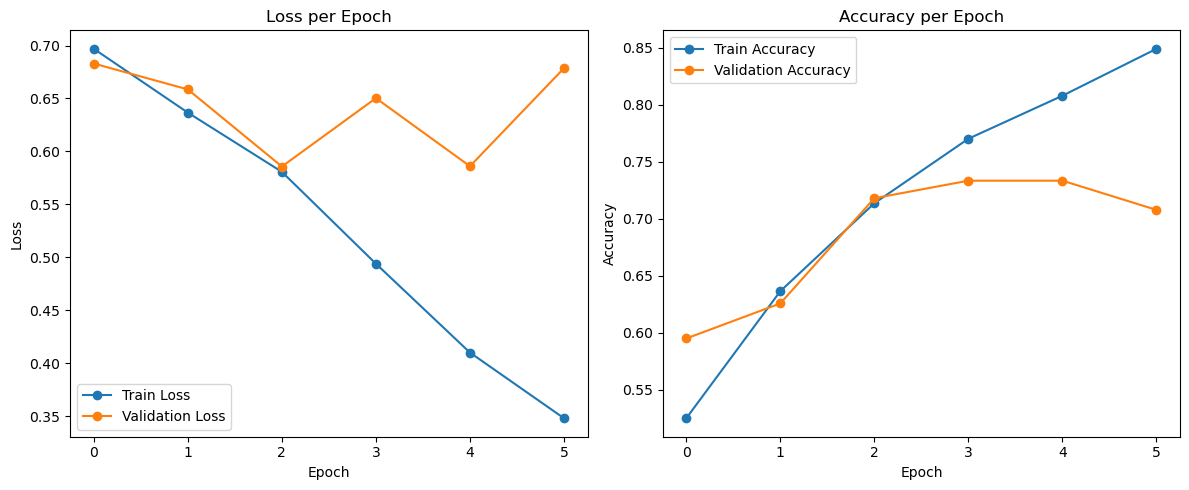

In [11]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
import torch
import torch.nn.functional as F

def generate_predictions(model, dataloader):
    model.eval()
    all_video_ids = []
    all_exist_ids = []
    all_probs = []
    all_preds = []
    all_labels = []
    all_constant_column = []  # This will store the constant value "EXIST2025"
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating Predictions"):
            batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
            #inputs = {k: v for k, v in batch.items() if k != "video_ids"}
            inputs = {k: v for k, v in batch.items() if k not in ["video_ids", "exist_ids"]}
            outputs = model(**inputs)
            logits = outputs.logits
            probs = F.softmax(logits, dim=1)  # Get probabilities from logits
            preds = torch.argmax(probs, dim=1)  # Get predicted class
            # Map the predictions to "YES" (1) or "NO" (0)
            preds_mapped = ["YES" if pred >=0.5 else "NO" for pred in preds.cpu().numpy()]
            
            constant_value = "EXIST2025"
            constant_column = [constant_value] * len(preds_mapped)
            
            all_exist_ids.extend(batch['exist_ids'])
            all_video_ids.extend(batch['video_ids'])
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds_mapped)
            all_labels.extend(batch['labels'].cpu().numpy())
            all_constant_column.extend(constant_column)

    return np.array(all_exist_ids), np.array(all_video_ids), np.array(all_probs), np.array(all_preds), np.array(all_labels), np.array(all_constant_column)


In [12]:
exist_ids, video_ids, probs, preds, labels, titles = generate_predictions(model, train_loader)

test_acc = accuracy_score(labels, preds)
test_f1 = f1_score(labels, preds, average="macro")

print(f"Train Accuracy: {test_acc:.4f}")
print(f"Train Macro F1 Score: {test_f1:.4f}")

df = pd.DataFrame({
    "test_case": titles,
    "id": exist_ids,
    "value": preds
})

df.to_csv("text_train_predictions.csv", index=False)
print("Saved predictions to text_train_predictions.csv")



Generating Predictions: 100%|██████████| 73/73 [00:17<00:00,  4.15it/s]


Test Accuracy: 0.9383
Test Macro F1 Score: 0.9370
Saved predictions to text_train_predictions.csv


In [13]:
exist_ids, video_ids, probs, preds, labels, titles = generate_predictions(model, test_loader)

test_acc = accuracy_score(labels, preds)
test_f1 = f1_score(labels, preds, average="macro")

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Macro F1 Score: {test_f1:.4f}")

df = pd.DataFrame({
    "test_case": titles,
    "id": exist_ids,
    "value": preds
})

df.to_csv("text_test_predictions.csv", index=False)
print("Saved predictions to text_test_predictions.csv")

Generating Predictions: 100%|██████████| 25/25 [00:05<00:00,  4.38it/s]

Test Accuracy: 0.7538
Test Macro F1 Score: 0.7497
Saved predictions to text_test_predictions.csv


In [14]:
exist_ids, video_ids, probs, preds, labels, titles = generate_predictions(model, val_loader)

test_acc = accuracy_score(labels, preds)
test_f1 = f1_score(labels, preds, average="macro")

print(f"Val Accuracy: {test_acc:.4f}")
print(f"Val Macro F1 Score: {test_f1:.4f}")

df = pd.DataFrame({
    "test_case": titles,
    "id": exist_ids,
    "value": preds
})

df.to_csv("text_val_predictions.csv", index=False)
print("Saved predictions to text_val_predictions.csv")

Generating Predictions: 100%|██████████| 25/25 [00:05<00:00,  4.32it/s]

Test Accuracy: 0.7231
Test Macro F1 Score: 0.6991
Saved predictions to text_val_predictions.csv


In [17]:
# Save just the model's state dict (weights)
torch.save(model.state_dict(), "model_weights.pt")


In [8]:
# Recreate the model architecture first
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained("roberta-large", num_labels=2)

# Load the saved weights
model.load_state_dict(torch.load("model_weights.pt", map_location=device))

# Move to device
model.to(device)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3761075/2181143520.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly a

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=Tru

In [ ]:
#The code below is for search grid which was used to decide the hyperparameters values
import itertools

# Define your hyperparameter search space
param_grid = {
    "learning_rate": [1e-5, 2e-5, 3e-5, 2e-6],
    "batch_size": [8, 16],
    "weight_decay": [0.0, 0.01],
    "num_frozen_layers": [0, 6, 12, 18, 20]  # NEW!
}

# Create all combinations
param_combinations = list(itertools.product(*param_grid.values()))
param_names = list(param_grid.keys())

best_val_acc = 0
best_params = None

for param_values in param_combinations:
    params = dict(zip(param_names, param_values))
    print(f"\nTraining with parameters: {params}")

    # Rebuild model and optimizer each time
    model = RobertaForSequenceClassification.from_pretrained("roberta-large", num_labels=2)
    model.to(device)

    # --- Freeze Layers ---
    if params["num_frozen_layers"] > 0:
        for idx, layer in enumerate(model.roberta.encoder.layer):
            if idx < params["num_frozen_layers"]:
                for param in layer.parameters():
                    param.requires_grad = False
        print(f"✅ Froze first {params['num_frozen_layers']} layers.")

    optimizer = torch.optim.AdamW(model.parameters(), 
                                  lr=params["learning_rate"], 
                                  weight_decay=params["weight_decay"])

    # Rebuild loaders if batch_size changes
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], shuffle=False)

    # --- Training ---
    for epoch in range(2):  # Short training for search
        model.train()
        for batch in train_loader:
            batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
            inputs = {k: v for k, v in batch.items() if k != "video_ids"}

            outputs = model(**inputs)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # --- Validation ---
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
            inputs = {k: v for k, v in batch.items() if k != "video_ids"}

            outputs = model(**inputs)
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch['labels'].cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    print(f"Validation Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = params

print(f"\n Best Validation Accuracy: {best_val_acc:.4f}")
print(f" Best Parameters: {best_params}")



Training with parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.6923

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.6308

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.6718

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.6410

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.6769

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.6718

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.7128

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.7179

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.7026

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.6872

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.6256

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.7128

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.6513

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.6051

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.6103

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.5128

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.6308

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.5795

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.6923

Training with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.6308

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.5744

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.7231

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.5692

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.6974

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.6718

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.6923

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.6923

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.7436

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.6821

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.6667

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.6974

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.7077

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.7179

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.5744

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.6615

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.6667

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.6821

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.7026

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.6000

Training with parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.5487

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.6923

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.5692

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.5692

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.4513

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.0, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.7282

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.5692

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.7282

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.7077

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.7231

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.01, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.6462

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.6564

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.5692

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.6308

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
Validation Accuracy: 0.7231

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.0, 'num_frozen_layers': 20}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 20 layers.
Validation Accuracy: 0.6718

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.5538

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 6}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 6 layers.
Validation Accuracy: 0.7333

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 12}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 12 layers.
Validation Accuracy: 0.5692

Training with parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.01, 'num_frozen_layers': 18}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Froze first 18 layers.
